In [1]:
from sklearn.metrics import mean_absolute_error as MSE
from cmcrameri import cm
from tqdm import tqdm
from common import *
from models import *

2021-12-14 23:20:06.499479: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-12-14 23:20:06.499517: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


# Reading in the data

In [2]:
df = pd.read_csv("../data/input_data/MAIN_DATASET.csv")

price = df['NO2_price'].values.reshape(-1,1)

price_days = seperate_column_to_days(price)

In [3]:
lookbehind = 7
input_width = lookbehind*24
horizon = 24
no_hours = input_width + horizon
hour_in_days = int(no_hours / 24)

price_dataset = []
for i in range(len(price_days) - hour_in_days+1):
    price_dataset.append(np.concatenate((price_days[i:i+hour_in_days])))

price_dataset = np.array(price_dataset)

scaler = MinMaxScaler()
price_dataset = scaler.fit_transform(price_dataset[:,:,0])
price_dataset = price_dataset[..., np.newaxis].astype(np.float32)

dataset = price_dataset
n,m,k = dataset.shape
print(n,m,k)

2145 192 1


In [4]:
train = int(0.7*n)
valid = int(0.9*n)
X_train = dataset[:train, :input_width]
X_valid = dataset[train:valid, :input_width]
X_test = dataset[valid:, :input_width]

Y = np.empty((n, input_width, horizon))
for step_ahead in range(1, horizon + 1):
    Y[:,:, step_ahead - 1] = dataset[:,step_ahead:step_ahead + input_width, 0]

Y_train = Y[:train]
Y_valid = Y[train:valid]
Y_test = Y[valid:]

X_train.shape=(1501, 168, 1)
X_valid.shape=(429, 168, 1)
X_test.shape=(215, 168, 1)
Y_train.shape=(1501, 168, 24)
Y_valid.shape=(429, 168, 24)
Y_test.shape=(215, 168, 24)


The idea behind this grid search is to first study which cells performs the best for our current dataset, with a univariate model

# Common parameters for Grid Search

In [5]:
epochs = 10
no_neurons = np.array([16,32,64,128])
mse_list_small = np.zeros((3, len(no_neurons)))
best_mse_small = np.inf*np.ones(3)

In [6]:
for n, neurons in enumerate(no_neurons):
    print(f"Iteration {n}")
    rnn = keras.models.Sequential([
        keras.layers.SimpleRNN(neurons, return_sequences=True, input_shape=[None, 1]),
        keras.layers.Dense(horizon)
    ])

    lstm = keras.models.Sequential([
        keras.layers.LSTM(neurons, return_sequences=True, input_shape=[None, 1]),
        keras.layers.Dense(horizon)
    ])

    gru = keras.models.Sequential([
        keras.layers.GRU(neurons, return_sequences=True, input_shape=[None, 1]),
        keras.layers.Dense(horizon)
    ])

    rnn.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
    lstm.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
    gru.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])

    rnn.fit(X_train, Y_train, epochs=epochs, validation_data=(X_valid, Y_valid), verbose=False)
    lstm.fit(X_train, Y_train, epochs=epochs, validation_data=(X_valid, Y_valid), verbose=False)
    gru.fit(X_train, Y_train, epochs=epochs, validation_data=(X_valid, Y_valid), verbose=False)

    Y_pred_rnn = rnn.predict(X_test)
    Y_pred_lstm = lstm.predict(X_test)
    Y_pred_gru = gru.predict(X_test)

    mse_rnn = MSE(Y_test[:,-1], Y_pred_rnn[:,-1])
    mse_lstm = MSE(Y_test[:,-1], Y_pred_lstm[:,-1])
    mse_gru = MSE(Y_test[:,-1], Y_pred_gru[:,-1])

    if mse_rnn < best_mse_small[0]:
        print(f"Found new best SimpleRNN mse {mse_rnn} with {neurons} neurons")
        best_mse_small[0] = mse_rnn
        fname = f"../data/models/small_rnn.pkl"
        save_model(rnn, fname)

    if mse_lstm < best_mse_small[1]:
        print(f"Found new best LSTM mse {mse_lstm} with {neurons} neurons")
        best_mse_small[1] = mse_lstm
        fname = f"../data/models/small_lstm.pkl"
        save_model(lstm, fname)

    if mse_gru < best_mse_small[2]:
        print(f"Found new best GRU mse {mse_gru} with {neurons} neurons")
        best_mse_small[2] = mse_gru
        fname = f"../data/models/small_gru.pkl"
        save_model(gru, fname)

    mse_list_small[0,n] = mse_rnn
    mse_list_small[1,n] = mse_lstm
    mse_list_small[2,n] = mse_gru



Iteration 0


2021-12-14 23:20:07.843938: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:925] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2021-12-14 23:20:07.844056: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-12-14 23:20:07.844125: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2021-12-14 23:20:07.844177: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2021-12-14 23:20:07.844227: W tensorflow/stream_executor/platform/default/dso_loader.cc:6

Found new best SimpleRNN mse 0.1564814715280506 with 16 neurons


2021-12-14 23:21:12.190700: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ram://a47c15be-65bd-469f-b261-f7284804817d/assets
Found new best LSTM mse 0.11912772070439293 with 16 neurons


INFO:tensorflow:Assets written to: ram://ebb54cea-9ef1-4d6a-9cd1-1a6ebc3374ec/assets


INFO:tensorflow:Assets written to: ram://ebb54cea-9ef1-4d6a-9cd1-1a6ebc3374ec/assets


Found new best GRU mse 0.11783184701197492 with 16 neurons


INFO:tensorflow:Assets written to: ram://eb6456f0-591b-4783-aa40-15eb76dec2e2/assets


INFO:tensorflow:Assets written to: ram://eb6456f0-591b-4783-aa40-15eb76dec2e2/assets


Iteration 1
Found new best SimpleRNN mse 0.1307345659884254 with 32 neurons
INFO:tensorflow:Assets written to: ram://eeaa8046-69a1-4abb-ab56-7d7d63c265b0/assets


INFO:tensorflow:Assets written to: ram://eeaa8046-69a1-4abb-ab56-7d7d63c265b0/assets


Found new best LSTM mse 0.11909048117202388 with 32 neurons


INFO:tensorflow:Assets written to: ram://d06e1572-3999-47e9-9243-3018a83a60d4/assets


INFO:tensorflow:Assets written to: ram://d06e1572-3999-47e9-9243-3018a83a60d4/assets


Found new best GRU mse 0.0914161777169622 with 32 neurons


INFO:tensorflow:Assets written to: ram://13096f87-d3f9-42f6-b73c-d6840b824aee/assets


INFO:tensorflow:Assets written to: ram://13096f87-d3f9-42f6-b73c-d6840b824aee/assets


Iteration 2
Found new best SimpleRNN mse 0.11208996423292421 with 64 neurons
INFO:tensorflow:Assets written to: ram://c9c51ba0-ab30-47a1-97ed-cb1e0269651e/assets


INFO:tensorflow:Assets written to: ram://c9c51ba0-ab30-47a1-97ed-cb1e0269651e/assets


Found new best LSTM mse 0.09401803232786882 with 64 neurons


INFO:tensorflow:Assets written to: ram://ebe01562-d59f-4290-b628-aa2e313ec291/assets


INFO:tensorflow:Assets written to: ram://ebe01562-d59f-4290-b628-aa2e313ec291/assets


Found new best GRU mse 0.08983860884442645 with 64 neurons


INFO:tensorflow:Assets written to: ram://627b7636-72bc-4720-864d-2ae7e8e6af86/assets


INFO:tensorflow:Assets written to: ram://627b7636-72bc-4720-864d-2ae7e8e6af86/assets


Iteration 3
Found new best SimpleRNN mse 0.07613025754390249 with 128 neurons
INFO:tensorflow:Assets written to: ram://972023ac-4b31-49f7-a502-46adf81ce124/assets


INFO:tensorflow:Assets written to: ram://972023ac-4b31-49f7-a502-46adf81ce124/assets


Found new best LSTM mse 0.09051073147369919 with 128 neurons


INFO:tensorflow:Assets written to: ram://bd0f0117-e616-45fa-b4d8-2ae28c5c444a/assets


INFO:tensorflow:Assets written to: ram://bd0f0117-e616-45fa-b4d8-2ae28c5c444a/assets


Found new best GRU mse 0.0849436012794081 with 128 neurons


INFO:tensorflow:Assets written to: ram://22ae4618-1aff-4043-b267-dc4e9e97bd61/assets


INFO:tensorflow:Assets written to: ram://22ae4618-1aff-4043-b267-dc4e9e97bd61/assets


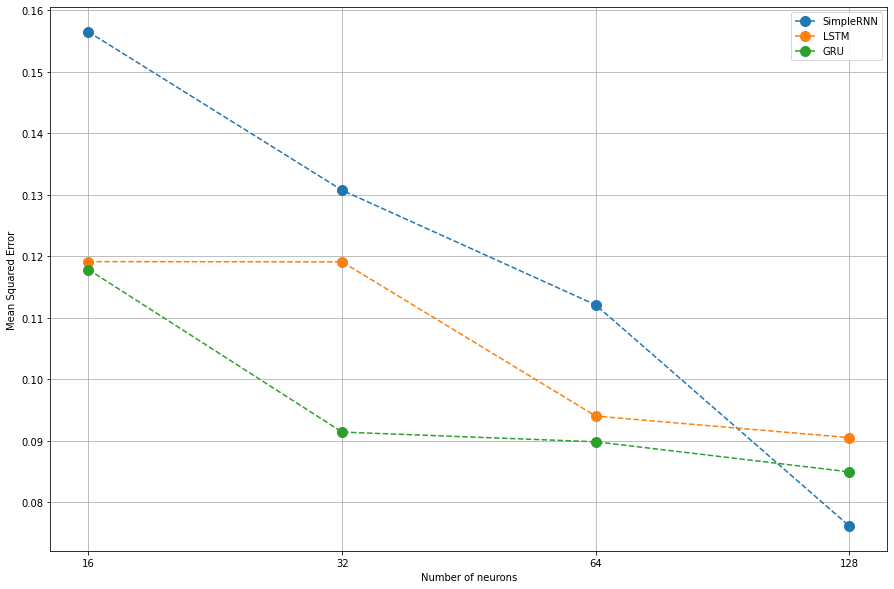

In [7]:
plt.figure(figsize=(15,10))
plt.plot(mse_list_small[0], '.--', markersize=20, label="SimpleRNN")
plt.plot(mse_list_small[1], '.--', markersize=20, label="LSTM")
plt.plot(mse_list_small[2], '.--', markersize=20, label="GRU")
plt.xticks(ticks = np.arange(4), labels=no_neurons)
plt.xlabel(f"Number of neurons")
plt.ylabel(f"Mean Squared Error")
plt.grid()
plt.legend()
#plt.savefig(f"../figures/small_architecture_grid_search.pdf")

# Perform the same gridsearch, but for large architecture

In [8]:
no_neurons = np.array([16,32,64,128])
mse_list = np.zeros((3, len(no_neurons), len(no_neurons)))
best_mse = np.inf*np.ones(3)

In [9]:
for n, neurons_first in enumerate(no_neurons):
    for m, neurons_second in enumerate(no_neurons):
        print(f"Iteration {n}{m}")
        rnn = keras.models.Sequential([
            keras.layers.SimpleRNN(neurons_first, return_sequences=True, input_shape=[None, 1]),
            keras.layers.SimpleRNN(neurons_second, return_sequences=True),
            keras.layers.Dense(horizon)
        ])

        lstm = keras.models.Sequential([
            keras.layers.LSTM(neurons_first, return_sequences=True, input_shape=[None, 1]),
            keras.layers.LSTM(neurons_second, return_sequences=True),
            keras.layers.Dense(horizon)
        ])

        gru = keras.models.Sequential([
            keras.layers.GRU(neurons_first, return_sequences=True, input_shape=[None, 1]),
            keras.layers.GRU(neurons_second, return_sequences=True),
            keras.layers.Dense(horizon)
        ])

        rnn.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
        lstm.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
        gru.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])

        rnn.fit(X_train, Y_train, epochs=epochs, validation_data=(X_valid, Y_valid), verbose=False)
        lstm.fit(X_train, Y_train, epochs=epochs, validation_data=(X_valid, Y_valid), verbose=False)
        gru.fit(X_train, Y_train, epochs=epochs, validation_data=(X_valid, Y_valid), verbose=False)

        Y_pred_rnn = rnn.predict(X_test)
        Y_pred_lstm = lstm.predict(X_test)
        Y_pred_gru = gru.predict(X_test)

        mse_rnn = MSE(Y_test[:,-1], Y_pred_rnn[:,-1])
        mse_lstm = MSE(Y_test[:,-1], Y_pred_lstm[:,-1])
        mse_gru = MSE(Y_test[:,-1], Y_pred_gru[:,-1])

        if mse_rnn < best_mse[0]:
            print(f"Found new best SimpleRNN mse {mse_rnn} with {neurons_first} and {neurons_second} neurons")
            best_mse[0] = mse_rnn
            fname = f"../data/models/large_rnn.pkl"
            save_model(rnn, fname)

        if mse_lstm < best_mse[1]:
            print(f"Found new best LSTM mse {mse_lstm} with {neurons_first} and {neurons_second} neurons")
            best_mse[1] = mse_lstm
            fname = f"../data/models/large_lstm.pkl"
            save_model(lstm, fname)

        if mse_gru < best_mse[2]:
            print(f"Found new best GRU mse {mse_gru} with {neurons_first} and {neurons_second} neurons")
            best_mse[2] = mse_gru
            fname = f"../data/models/large_gru.pkl"
            save_model(gru, fname)

        mse_list[0,n,m] = mse_rnn
        mse_list[1,n,m] = mse_lstm
        mse_list[2,n,m] = mse_gru

Iteration 00
Found new best SimpleRNN mse 0.17797824312062524 with 16 and 16 neurons
INFO:tensorflow:Assets written to: ram://6e98e3f8-450c-424a-a4c3-99644c0d0836/assets


INFO:tensorflow:Assets written to: ram://6e98e3f8-450c-424a-a4c3-99644c0d0836/assets


Found new best LSTM mse 0.11918401681958539 with 16 and 16 neurons


INFO:tensorflow:Assets written to: ram://e2c1e7de-a2ca-4acb-9823-0f94ac912740/assets


INFO:tensorflow:Assets written to: ram://e2c1e7de-a2ca-4acb-9823-0f94ac912740/assets


Found new best GRU mse 0.10812906619013056 with 16 and 16 neurons


INFO:tensorflow:Assets written to: ram://8abbf21c-2037-4a5e-b76e-480276671e72/assets


INFO:tensorflow:Assets written to: ram://8abbf21c-2037-4a5e-b76e-480276671e72/assets


Iteration 01
Found new best SimpleRNN mse 0.10903281135339875 with 16 and 32 neurons
INFO:tensorflow:Assets written to: ram://860a2300-562a-4f78-b59f-60852a68a644/assets


INFO:tensorflow:Assets written to: ram://860a2300-562a-4f78-b59f-60852a68a644/assets


Found new best LSTM mse 0.1024411859614166 with 16 and 32 neurons


INFO:tensorflow:Assets written to: ram://f702f9af-2370-476a-b23d-f4051a803e54/assets


INFO:tensorflow:Assets written to: ram://f702f9af-2370-476a-b23d-f4051a803e54/assets


Found new best GRU mse 0.0980141423358154 with 16 and 32 neurons


INFO:tensorflow:Assets written to: ram://1b81b24b-ec27-48e4-a08d-503e1d92a2ab/assets


INFO:tensorflow:Assets written to: ram://1b81b24b-ec27-48e4-a08d-503e1d92a2ab/assets


Iteration 02
Found new best SimpleRNN mse 0.09700182079246983 with 16 and 64 neurons
INFO:tensorflow:Assets written to: ram://83f5ca85-e610-4462-8b09-4b95e57dac99/assets


INFO:tensorflow:Assets written to: ram://83f5ca85-e610-4462-8b09-4b95e57dac99/assets


Found new best LSTM mse 0.10208826301240075 with 16 and 64 neurons


INFO:tensorflow:Assets written to: ram://bf51d4a9-d01a-4f0c-b304-0ba1cafa6c55/assets


INFO:tensorflow:Assets written to: ram://bf51d4a9-d01a-4f0c-b304-0ba1cafa6c55/assets


Found new best GRU mse 0.08376749867269849 with 16 and 64 neurons


INFO:tensorflow:Assets written to: ram://18c7b495-9d42-4223-86b3-9d6a45d53c04/assets


INFO:tensorflow:Assets written to: ram://18c7b495-9d42-4223-86b3-9d6a45d53c04/assets


Iteration 03
Found new best SimpleRNN mse 0.08053608687272952 with 16 and 128 neurons
INFO:tensorflow:Assets written to: ram://7d3848ac-74f9-4461-94d0-74fc029ed209/assets


INFO:tensorflow:Assets written to: ram://7d3848ac-74f9-4461-94d0-74fc029ed209/assets


Found new best LSTM mse 0.09275335177565909 with 16 and 128 neurons


INFO:tensorflow:Assets written to: ram://13b762b4-c53b-440d-b025-1d3e478b518b/assets


INFO:tensorflow:Assets written to: ram://13b762b4-c53b-440d-b025-1d3e478b518b/assets


Iteration 10
Iteration 11
Iteration 12
Iteration 13
Found new best LSTM mse 0.08641150524222176 with 32 and 128 neurons


INFO:tensorflow:Assets written to: ram://95f9c422-5b62-4546-b7ea-b1dcf5cc3297/assets


INFO:tensorflow:Assets written to: ram://95f9c422-5b62-4546-b7ea-b1dcf5cc3297/assets


Found new best GRU mse 0.08066217499059249 with 32 and 128 neurons


INFO:tensorflow:Assets written to: ram://3c579dd7-c11a-4f88-b234-89b4693720fd/assets


INFO:tensorflow:Assets written to: ram://3c579dd7-c11a-4f88-b234-89b4693720fd/assets


Iteration 20
Iteration 21
Iteration 22
Iteration 23
Found new best SimpleRNN mse 0.07257373842089163 with 64 and 128 neurons
INFO:tensorflow:Assets written to: ram://e01fec28-cbe1-4932-b89a-3ccaa83329b1/assets


INFO:tensorflow:Assets written to: ram://e01fec28-cbe1-4932-b89a-3ccaa83329b1/assets


Iteration 30
Iteration 31
Iteration 32
Iteration 33
Found new best SimpleRNN mse 0.06939392309550739 with 128 and 128 neurons
INFO:tensorflow:Assets written to: ram://1fa21671-8aaf-469b-a3b4-d83407686739/assets


INFO:tensorflow:Assets written to: ram://1fa21671-8aaf-469b-a3b4-d83407686739/assets


In [10]:
print(mse_list)
print(best_mse)

[[[0.17797824 0.10903281 0.09700182 0.08053609]
  [0.15108914 0.11841515 0.10343045 0.08740797]
  [0.12654837 0.11391362 0.08522634 0.07257374]
  [0.11148168 0.11281334 0.08831262 0.06939392]]

 [[0.11918402 0.10244119 0.10208826 0.09275335]
  [0.13179839 0.1025492  0.10117043 0.08641151]
  [0.11690016 0.10052218 0.09728017 0.09017644]
  [0.11013928 0.1037902  0.09758631 0.08719932]]

 [[0.10812907 0.09801414 0.0837675  0.08600341]
  [0.11310487 0.08687814 0.08387653 0.08066217]
  [0.11194858 0.09024661 0.08597667 0.08928518]
  [0.09169727 0.0826923  0.08835175 0.08517792]]]
[0.06939392 0.08641151 0.08066217]


From these results, the best models are
* SimpleRNN 128 and 128 neurons @ 0.06939392 MSE
* LSTM 32 and 128 neurons @ 0.08641151
* GRU 32 and 128 neurons @ 0.08066217